## Implémentez un modèle de scoring

### Contexte du projet

L'objectif de ce projet est de construire un modèle de scoring de la probabilité de défaut de paiement d'un client pour un prêt bancaire.

L'étape suivante consistera à développer une API de ce modèle qui sera déployé sur le cloud, puis à créer un dashboard interactif pour présenter les résultats.

### Entrainement du modèle avec suivi MLFlow

Fold 1 AUC: 0.770315
Fold 2 AUC: 0.766264
Fold 3 AUC: 0.765809
Fold 4 AUC: 0.767224
Fold 5 AUC: 0.769124
Full AUC score 0.767719
Optimal threshold: 0.5199999999999998, Minimal cost: 158834


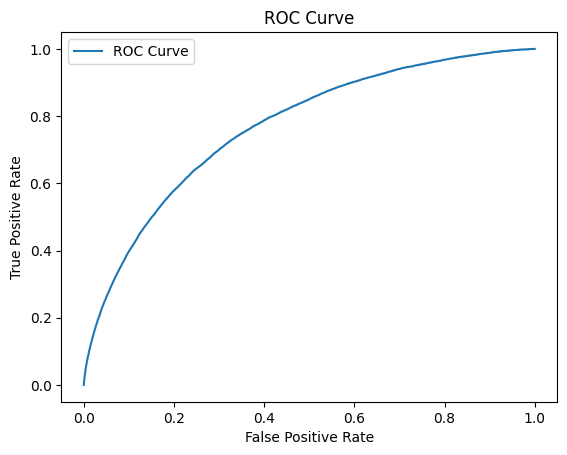

2024/11/23 02:51:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [19]:
import numpy as np
import pandas as pd
import gc
import time
import mlflow
import mlflow.lightgbm
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}s")

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def application_train_test(num_rows=None, nan_as_category=False):
    df = pd.read_csv('application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('application_test.csv', nrows=num_rows)
    df = df._append(test_df).reset_index(drop=True)

    # Nettoyage des colonnes pour éviter les caractères spéciaux et majuscules
    df.columns = df.columns.str.replace('[^A-Za-z0-9]+', '', regex=True).str.lower()

    # Conserver skidcurr pour référence client, mais ne pas l'utiliser comme feature d'entraînement
    if 'skidcurr' in df.columns:
        client_ids = df['skidcurr']
    else:
        raise ValueError("Column 'skidcurr' is missing in the data.")

    df = df[df['codegender'] != 'XNA']
    for bin_feature in ['codegender', 'flagowncar', 'flagownrealty']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    df, cat_cols = one_hot_encoder(df, nan_as_category)

    df.columns = df.columns.str.replace('[^A-Za-z0-9]+', '', regex=True)

    # Features d'ingénierie
    df['daysemployedperc'] = df['daysemployed'] / df['daysbirth']
    df['incomecreditperc'] = df['amtincometotal'] / df['amtcredit']
    df['incomeperperson'] = df['amtincometotal'] / df['cntfammembers']
    df['annuityincomeperc'] = df['amtannuity'] / df['amtincometotal']
    df['paymentrate'] = df['amtannuity'] / df['amtcredit']

    # Ajouter l'identifiant skidcurr aux données finales pour référence, sans l'entraîner
    df['skidcurr'] = client_ids

    # Sauvegarder le fichier complet avec skidcurr pour utilisation dans l'API
    df.to_csv('final_processed_data_with_ids.csv', index=False)

    # Définir les features sans l'identifiant client pour l'entraînement
    feats = [f for f in df.columns if f not in ['target', 'skidcurr', 'index']]
    return df, feats

# Fonction pour calculer le coût métier
def calculate_cost(y_true, y_pred, fn_cost=10, fp_cost=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = (fn * fn_cost) + (fp * fp_cost)
    return total_cost

# Optimisation du seuil pour minimiser le coût métier
def find_optimal_threshold(y_true, y_proba, fn_cost=10, fp_cost=1):
    best_threshold = 0.5
    best_cost = float('inf')
    thresholds = np.arange(0.1, 1.0, 0.01)
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = calculate_cost(y_true, y_pred, fn_cost, fp_cost)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    return best_threshold, best_cost

def kfold_lightgbm(df, feats, num_folds, stratified=False, debug=False):
    train_df = df[df['target'].notnull()]
    test_df = df[df['target'].isnull()]
    del df
    gc.collect()

    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    mlflow.set_experiment('credit_scoring_with_id')
    final_model = None  # Variable pour stocker le dernier modèle entraîné

    with mlflow.start_run() as run:
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
            train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
            valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

            clf = LGBMClassifier(
                nthread=4,
                n_estimators=10000,
                learning_rate=0.02,
                num_leaves=34,
                colsample_bytree=0.9497036,
                subsample=0.8715623,
                max_depth=8,
                reg_alpha=0.041545473,
                reg_lambda=0.0735294,
                min_split_gain=0.0222415,
                min_child_weight=39.3259775,
                class_weight='balanced',
                silent=-1,
                verbose=-1,
                early_stopping_round=200
            )

            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='auc')

            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            print(f'Fold {n_fold + 1} AUC: {roc_auc_score(valid_y, oof_preds[valid_idx]):.6f}')

            final_model = clf

            del clf, train_x, train_y, valid_x, valid_y
            gc.collect()

        auc_score = roc_auc_score(train_df['target'], oof_preds)
        print(f'Full AUC score {auc_score:.6f}')
        mlflow.log_metric('auc', auc_score)

        optimal_threshold, minimal_cost = find_optimal_threshold(train_df['target'], oof_preds)
        print(f'Optimal threshold: {optimal_threshold}, Minimal cost: {minimal_cost}')

        fpr, tpr, thresholds = roc_curve(train_df['target'], oof_preds)
        plt.plot(fpr, tpr, label="ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="best")
        plt.show()

        mlflow.log_metric('minimal_cost', minimal_cost)
        mlflow.log_param('optimal_threshold', optimal_threshold)
        if final_model:
            mlflow.lightgbm.log_model(final_model, 'model')

    return feature_importance_df, optimal_threshold, train_df, final_model

# Charger et préparer les données, puis exécuter le modèle
df, feats = application_train_test()
feature_importance_df, optimal_threshold, train_df, final_model = kfold_lightgbm(df, feats, num_folds=5)

In [10]:
import joblib

# Charger le modèle depuis le fichier .pkl
model = joblib.load("lightgbm_model.pkl")


In [11]:
# Charger les données de test
df_test = pd.read_csv("final_processed_data_with_ids_full.csv")

# Extraire les features et la cible
X_test = df_test[feats]  # 'feats' correspond aux colonnes utilisées pour entraîner le modèle
y_test = df_test['target']


In [12]:
# Calculer les probabilités
y_proba = model.predict_proba(X_test)[:, 1]

# Appliquer le seuil optimal pour obtenir les prédictions
y_pred = (y_proba >= optimal_threshold).astype(int)


In [13]:
mask = y_test.notna()
y_test = y_test[mask]
y_pred = y_pred[mask]  # Assurez-vous de filtrer y_pred de la même manière


### Matrice de confusion

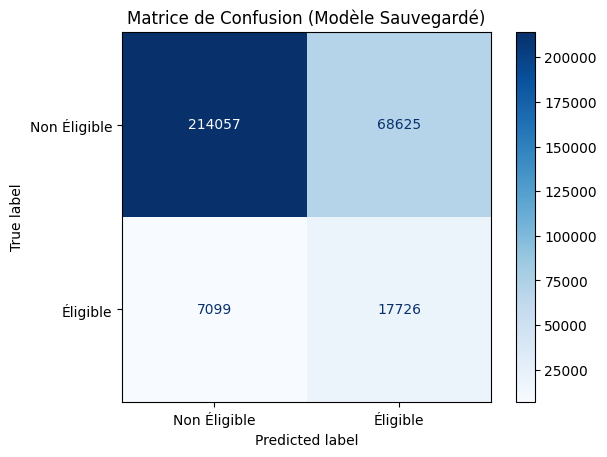

Faux négatifs (FN): 7099, Faux positifs (FP): 68625
Coût métier total : 139615


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Éligible", "Éligible"])
disp.plot(cmap='Blues')
plt.title("Matrice de Confusion (Modèle Sauvegardé)")
plt.show()

# Calcul du coût métier
fn_cost = 10
fp_cost = 1
tn, fp, fn, tp = cm.ravel()
total_cost = (fn * fn_cost) + (fp * fp_cost)

print(f"Faux négatifs (FN): {fn}, Faux positifs (FP): {fp}")
print(f"Coût métier total : {total_cost}")


### Feature Importance

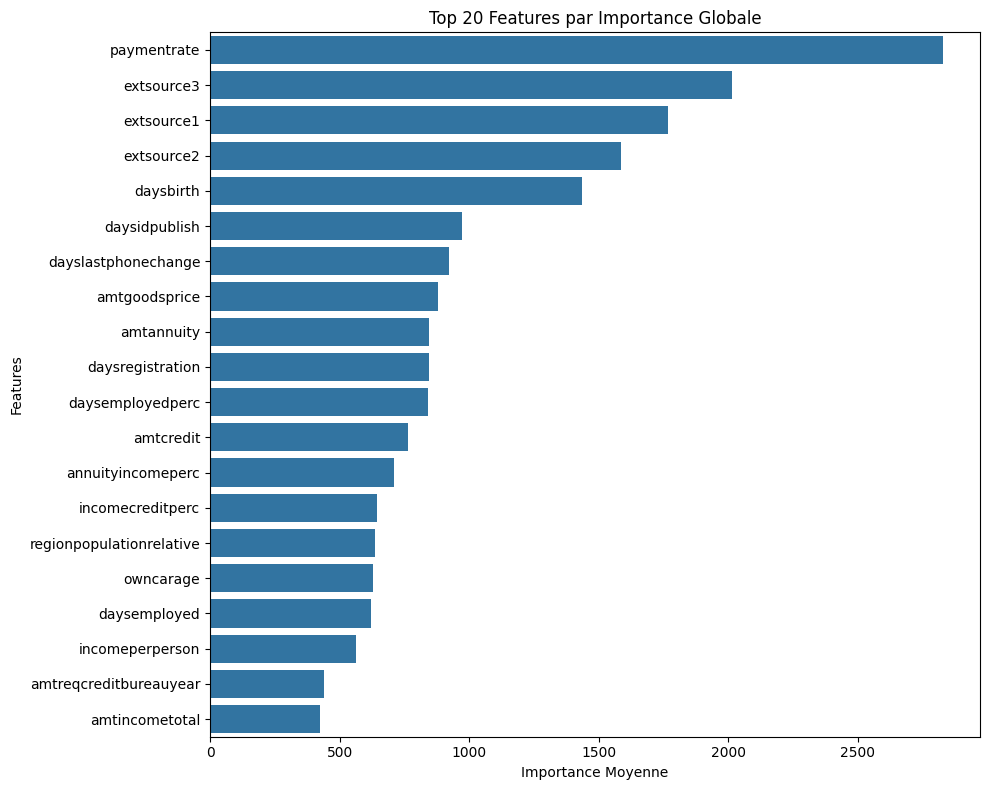

In [15]:
# Analyse de la Feature Importance Globale
import seaborn as sns

def plot_feature_importance(feature_importance_df, top_n=20):
    """Afficher la feature importance globale."""
    # Calculer l'importance moyenne par feature
    mean_importance = (
        feature_importance_df.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
    )
    plt.figure(figsize=(10, 8))
    sns.barplot(x=mean_importance, y=mean_importance.index)
    plt.title("Top 20 Features par Importance Globale")
    plt.xlabel("Importance Moyenne")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

# Appeler la fonction pour afficher le graphique
plot_feature_importance(feature_importance_df)


Client 1 :


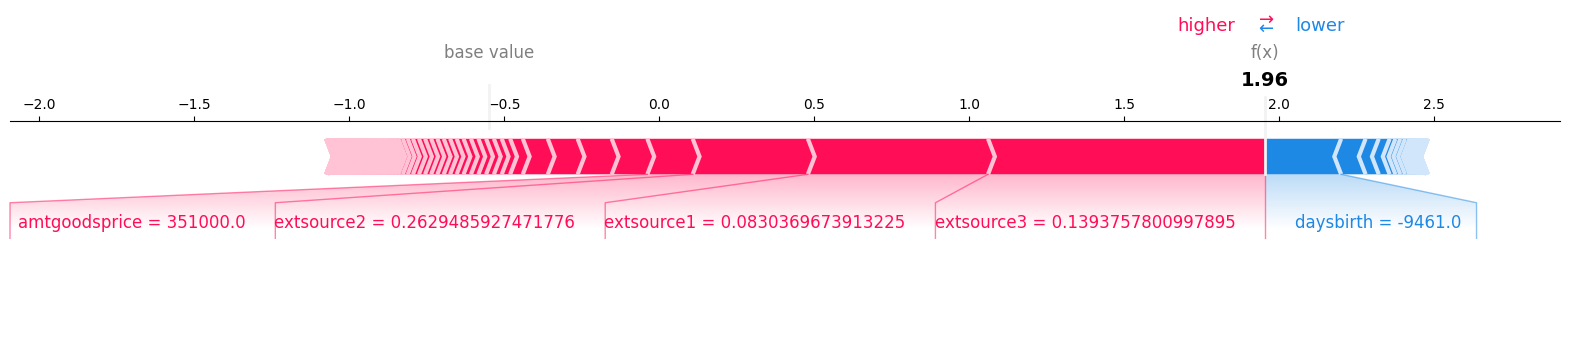

Client 2 :


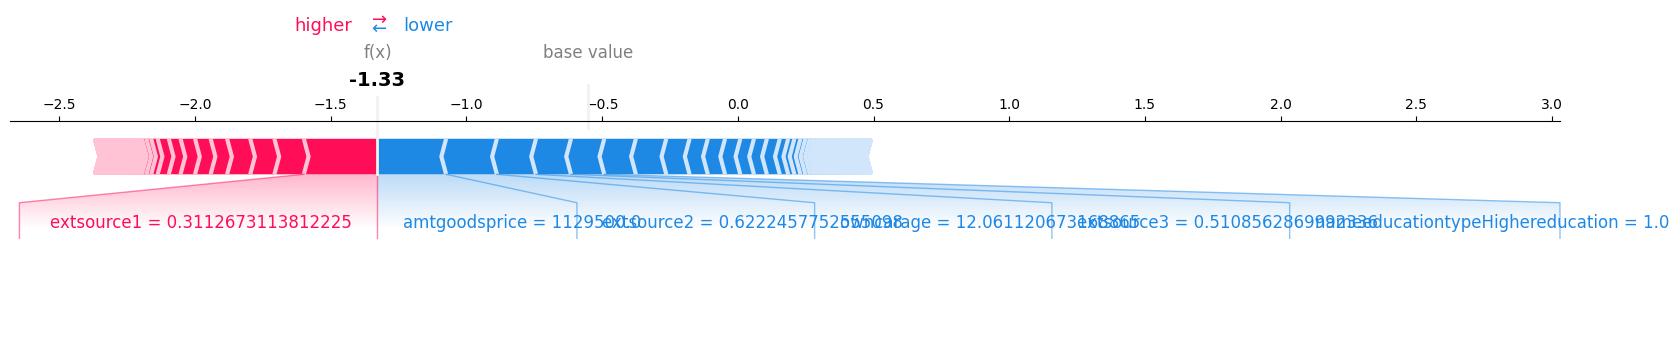

Client 3 :


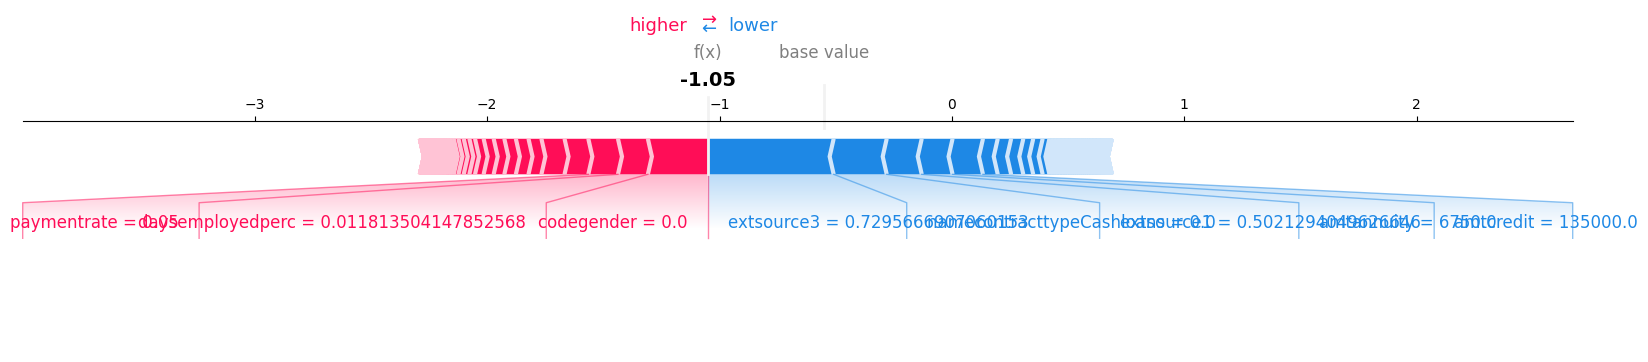

Client 4 :


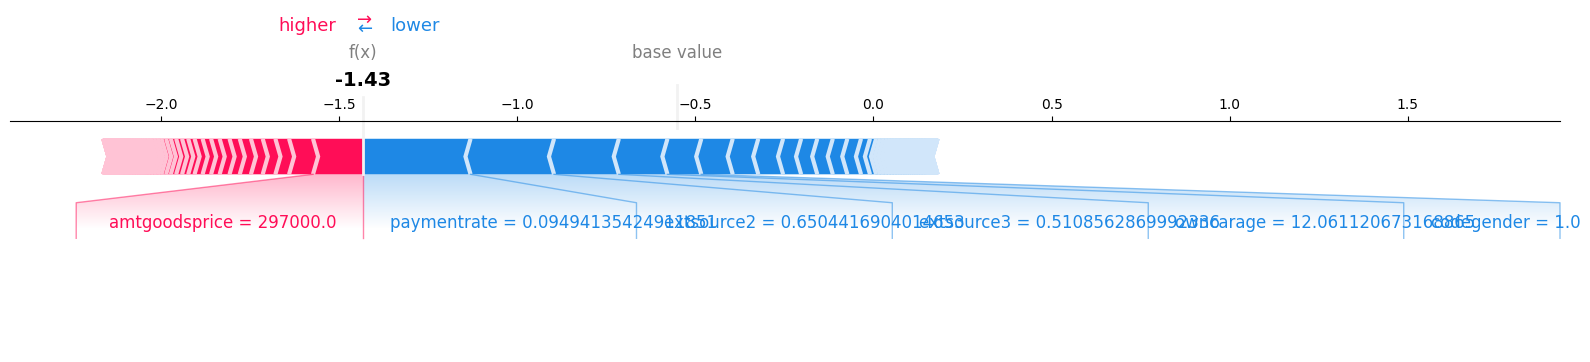

Client 5 :


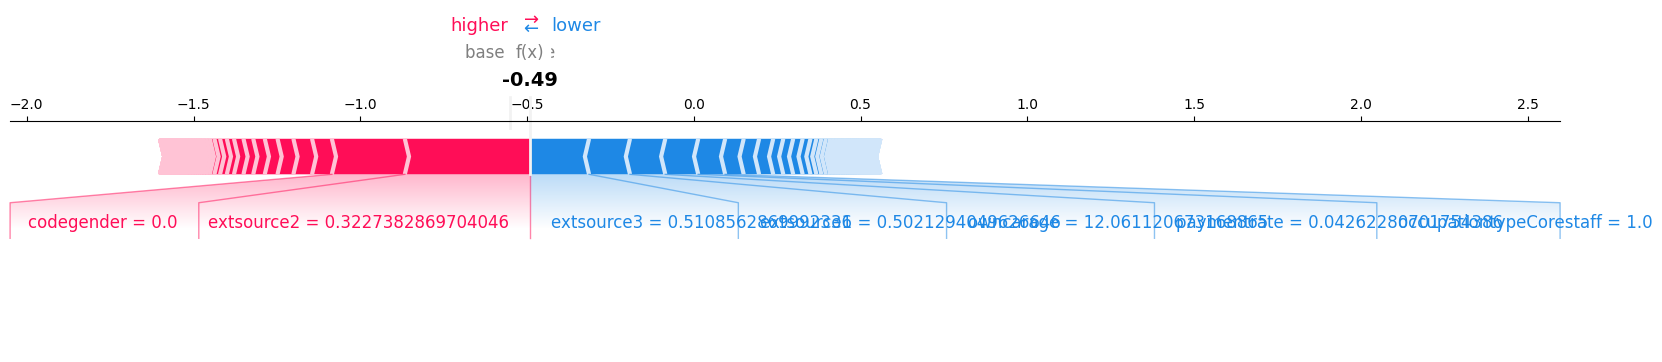

Client 6 :


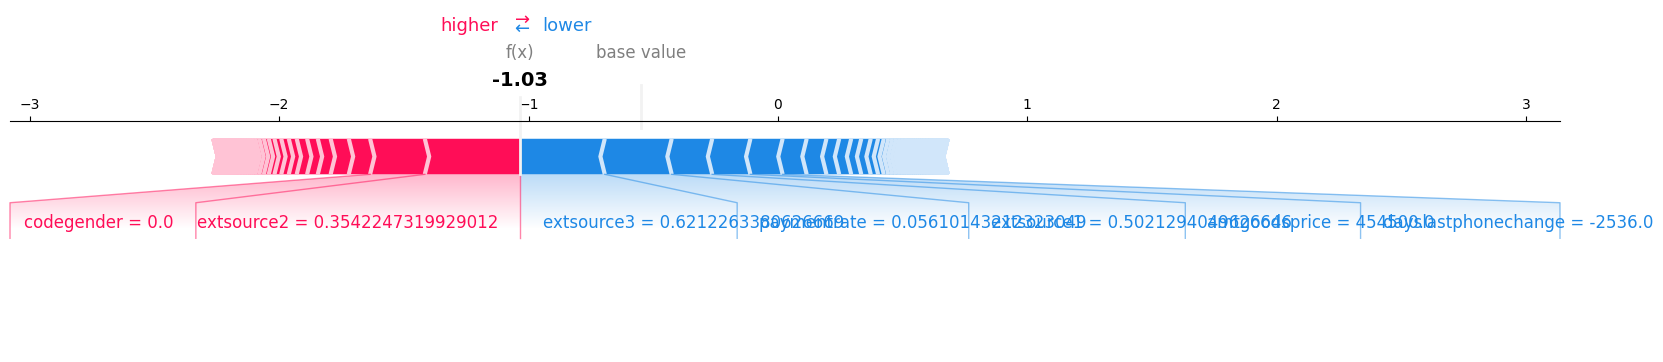

Client 7 :


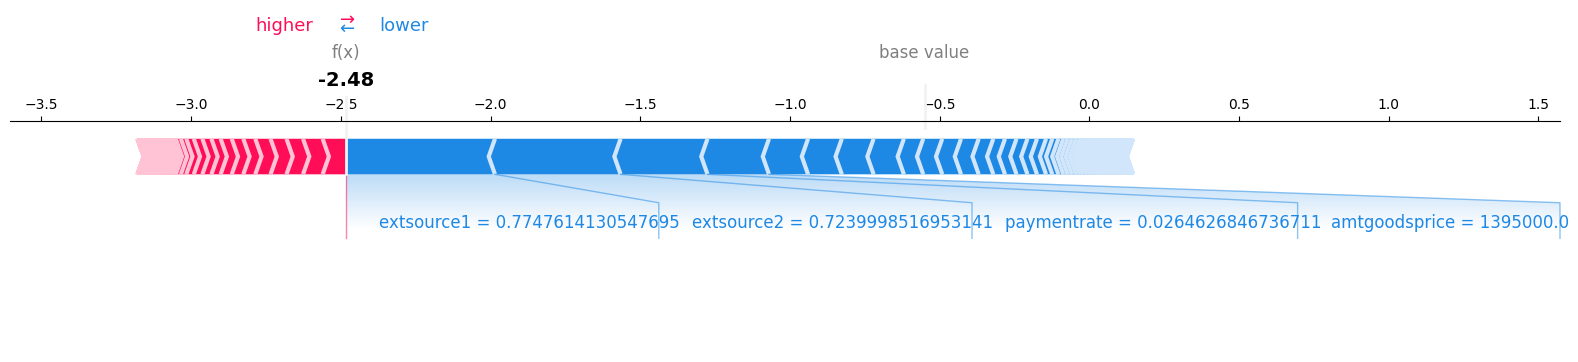

Client 8 :


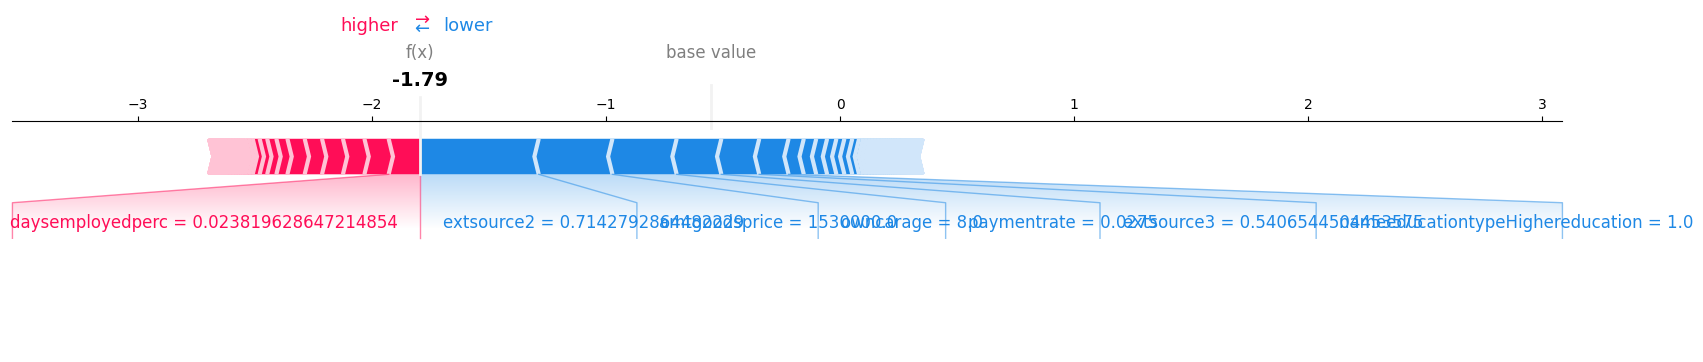

Client 9 :


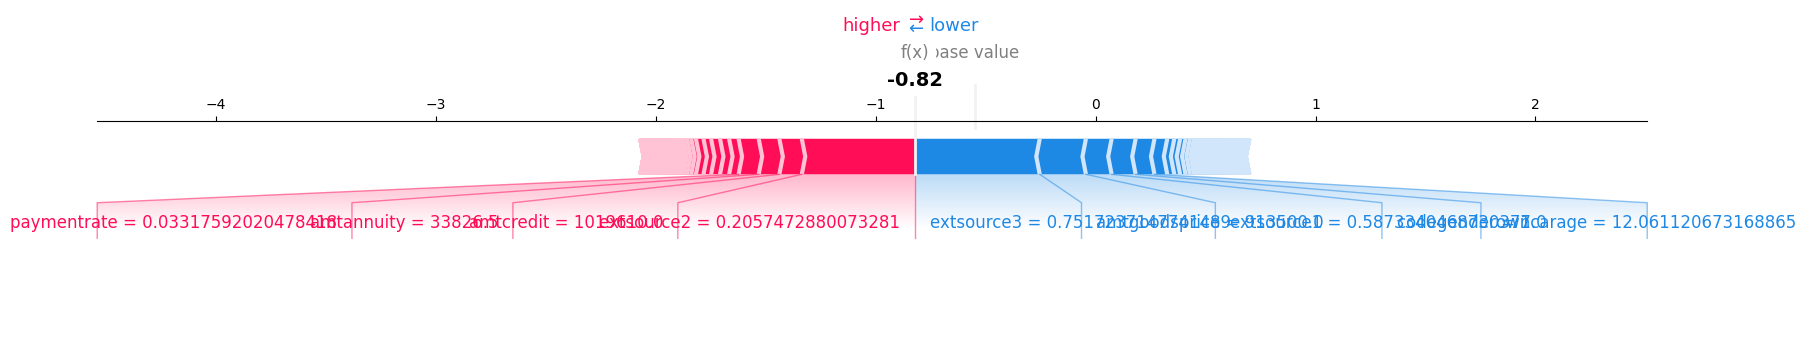

Client 10 :


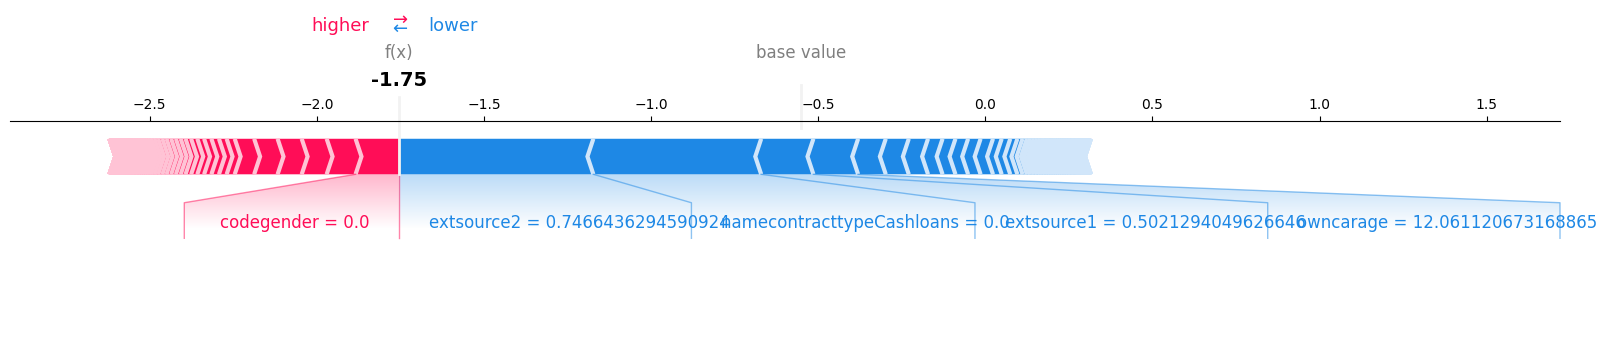

In [27]:
import shap

# Créer un explainer SHAP pour le modèle final
explainer = shap.TreeExplainer(final_model)

# Sélectionnez un échantillon des données de test
sample_data = train_df[feats].iloc[:10]

# Calculer les valeurs SHAP pour l'échantillon
shap_values = explainer(sample_data)  


# Afficher les graphiques d'importance locale pour les 10 premières instances
for i in range(10):
    print(f"Client {i + 1} :")
    shap.force_plot(
        shap_values.base_values[i],  # Base value pour l'instance
        shap_values.values[i],       # Valeurs SHAP pour l'instance
        sample_data.iloc[i],         # Instance analysée
        matplotlib=True
    )


### Data drift

In [29]:
import pandas as pd
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Charger les données
reference_data = pd.read_csv("application_train.csv")  # Données utilisées à l'entraînement
new_data = pd.read_csv("application_test.csv")         # Données simulant la production

# Nettoyer et prétraiter les colonnes pour qu'elles correspondent
reference_data.columns = reference_data.columns.str.replace('[^A-Za-z0-9]+', '', regex=True).str.lower()
new_data.columns = new_data.columns.str.replace('[^A-Za-z0-9]+', '', regex=True).str.lower()

# S'assurer que les mêmes colonnes sont présentes
common_columns = set(reference_data.columns).intersection(set(new_data.columns))
reference_data = reference_data[list(common_columns)]
new_data = new_data[list(common_columns)]

# Initialiser un rapport Evidently pour le Data Drift
data_drift_report = Report(metrics=[DataDriftPreset()])

# Générer le rapport
data_drift_report.run(reference_data=reference_data, current_data=new_data)

# Sauvegarder le rapport dans un fichier HTML
data_drift_report.save_html("data_drift_report.html")

print("Le rapport de Data Drift a été généré et sauvegardé sous 'data_drift_report.html'.")


Le rapport de Data Drift a été généré et sauvegardé sous 'data_drift_report.html'.
